# Medical Keywords Extraction using Transformer

## Objectives

At the end of the experiment, you will be able to :

* perform data preprocessing, EDA and feature extraction on the Medical Transcription dataset
* build transformer components - positional embedding, encoder, decoder, etc
* train a transformer model for keywords extraction
* create function to perform inference using trained transformer
* use the gradio library to generate a customizable UI for displaying the extracted keywords

## Dataset description

The dataset used in this project is Medical transcription dataset. It contains sample medical transcriptions for various medical specialties.

The data is in CSV format with below features:

- **description**

- **medical_specialty**

- **sample_name**

- **transcription**

- **keywords**

## Information

Medical transcriptions are textual records of patient-doctor interactions, medical procedures, clinical findings, and more. Extracting keywords from these transcriptions can provide valuable insights into a patient's health status, medical history, and treatment plans.

* Significance:

  - Data Summarization: Keyword extraction helps in summarizing lengthy medical transcriptions, making it easier for healthcare professionals to quickly understand the patient's medical history.

  - Search and Retrieval: Extracted keywords can be used to index medical records, facilitating faster search and retrieval of relevant documents.

  - Trend Analysis: By analyzing frequently occurring keywords, healthcare institutions can identify common ailments, treatment outcomes, and more.

* Applications:

  - Clinical Decision Support: Extracted keywords can be used to develop clinical decision support systems that provide real-time suggestions to healthcare professionals.
  - Patient Monitoring: By continuously analyzing the keywords from a patient's medical transcriptions, healthcare systems can monitor the patient's health and predict potential health risks.
  - Research: Medical researchers can use extracted keywords to identify trends, study disease outbreaks, and understand treatment efficacies.
  - Billing and Insurance: Keywords can help in automating the medical coding process, which is essential for billing and insurance claims.

### Problem Statement

Build a transformer model for performing keywords extraction on medical transcription dataset.

### Import required packages

In [ ]:
import numpy as np
import pandas as pd
import re
import random
import string
from string import digits
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#@title Download the dataset
!wget -q https://cdn.iisc.talentsprint.com/AIandMLOps/Datasets/Medical_transcription_dataset.csv
!ls | grep ".csv"

Medical_transcription_dataset.csv


**Step 1: Read the Medical_transcription_dataset.csv dataset**

In [ ]:
# Load the dataset
df = pd.read_csv('Medical_transcription_dataset.csv')
df.head(2)

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. In the past, she has tr...","allergy / immunology, allergic rhinitis, allergies, asthma, nasal sprays, rhinitis, nasal, erythematous, allegra, sprays, allergic,"
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. He exercises three times a week at...","bariatrics, laparoscopic gastric bypass, weight loss programs, gastric bypass, atkin's diet, weight watcher's, body weight, laparoscopic gastric, weight loss, pounds, months, weight, laparoscopic,..."


In [ ]:
df.shape

(4999, 6)

In [ ]:
# A transcription text from dataset
df['transcription'][0]

'SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa was erythematous and swollen.  Only clear drainage was seen.  TMs were clear.,Neck:  Supple without adenopathy.,

In [ ]:
# A keywords text from dataset
df['keywords'][0]

'allergy / immunology, allergic rhinitis, allergies, asthma, nasal sprays, rhinitis, nasal, erythematous, allegra, sprays, allergic,'

### Pre-processing and EDA

**Step 2: Perform below operations on the dataset**

- Remove unnecessary columns - 'Unnamed: 0'
- Handle missing values
- Remove rows from data where `keywords` is only single empty space ' $ $ '
- Remove duplicates from data considering `transcription` and `keywords` columns


- **Remove unnecessary columns - 'Unnamed: 0'**

In [ ]:
df.columns

Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')

In [ ]:
df = df.drop(['Unnamed: 0'], axis=1)
df.head(2)

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. In the past, she has tr...","allergy / immunology, allergic rhinitis, allergies, asthma, nasal sprays, rhinitis, nasal, erythematous, allegra, sprays, allergic,"
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. He exercises three times a week at...","bariatrics, laparoscopic gastric bypass, weight loss programs, gastric bypass, atkin's diet, weight watcher's, body weight, laparoscopic gastric, weight loss, pounds, months, weight, laparoscopic,..."


- **Handle missing values**

In [ ]:
df.isna().sum()

,0
description,0
medical_specialty,0
sample_name,0
transcription,33
keywords,1068


In [ ]:
# Drop missing values
df = df.dropna()
df.shape

(3898, 5)

In [ ]:
df.isna().sum()

,0
description,0
medical_specialty,0
sample_name,0
transcription,0
keywords,0


- **Remove rows from data where `keywords` is only single empty space ' '**

In [ ]:
# Count of rows where keywords are ' '
df[df['keywords'] == ' '].shape

(81, 5)

In [ ]:
df.shape

(3898, 5)

In [ ]:
# Remove rows where keywords are ' '
idx_to_remove = df[df['keywords'] == ' '].index
df = df.drop(index = idx_to_remove)

In [ ]:
df.shape

(3817, 5)

In [ ]:
df[df['keywords'] == ' '].shape

(0, 5)

- **Remove duplicates from data considering `transcription` and `keywords` columns**

In [ ]:
# Check duplicates
df.duplicated(subset=['transcription', 'keywords']).sum()

0

In [ ]:
df.shape

(3817, 5)

**Step 3: Display  all the categories of `medical_specialty` and their counts in the dataset**



In [ ]:
# Displaying the distinct categories of medical specialty
print(df['medical_specialty'].unique())

[' Allergy / Immunology' ' Bariatrics' ' Cardiovascular / Pulmonary'
 ' Dentistry' ' Urology' ' General Medicine' ' Surgery'
 ' Speech - Language' ' SOAP / Chart / Progress Notes' ' Sleep Medicine'
 ' Rheumatology' ' Radiology' ' Psychiatry / Psychology' ' Podiatry'
 ' Physical Medicine - Rehab' ' Pediatrics - Neonatal' ' Pain Management'
 ' Orthopedic' ' Ophthalmology' ' Office Notes' ' Obstetrics / Gynecology'
 ' Neurosurgery' ' Neurology' ' Nephrology' ' Letters'
 ' Lab Medicine - Pathology' ' IME-QME-Work Comp etc.'
 ' Hospice - Palliative Care' ' Hematology - Oncology' ' Gastroenterology'
 ' ENT - Otolaryngology' ' Endocrinology' ' Emergency Room Reports'
 ' Discharge Summary' ' Diets and Nutritions' ' Dermatology'
 ' Cosmetic / Plastic Surgery' ' Consult - History and Phy.'
 ' Chiropractic']


In [ ]:
# Total categories
print(df['medical_specialty'].nunique())

39


In [ ]:
# Displaying the distinct categories of medical specialty and the number of records belonging to each category
print(df['medical_specialty'].value_counts())

medical_specialty
 Surgery                          1008
 Orthopedic                        296
 Cardiovascular / Pulmonary        276
 Radiology                         248
 Consult - History and Phy.        220
 Gastroenterology                  193
 Neurology                         162
 SOAP / Chart / Progress Notes     140
 Urology                           139
 General Medicine                  137
 Obstetrics / Gynecology           128
 ENT - Otolaryngology               83
 Neurosurgery                       79
 Ophthalmology                      79
 Discharge Summary                  76
 Nephrology                         63
 Hematology - Oncology              60
 Pain Management                    58
 Podiatry                           42
 Office Notes                       40
 Pediatrics - Neonatal              38
 Emergency Room Reports             29
 Cosmetic / Plastic Surgery         25
 Dentistry                          24
 Dermatology                        24
 Letter

**Step 4: Create a pie plot depicting the percentage of `medical_specialty` distributions category-wise.**

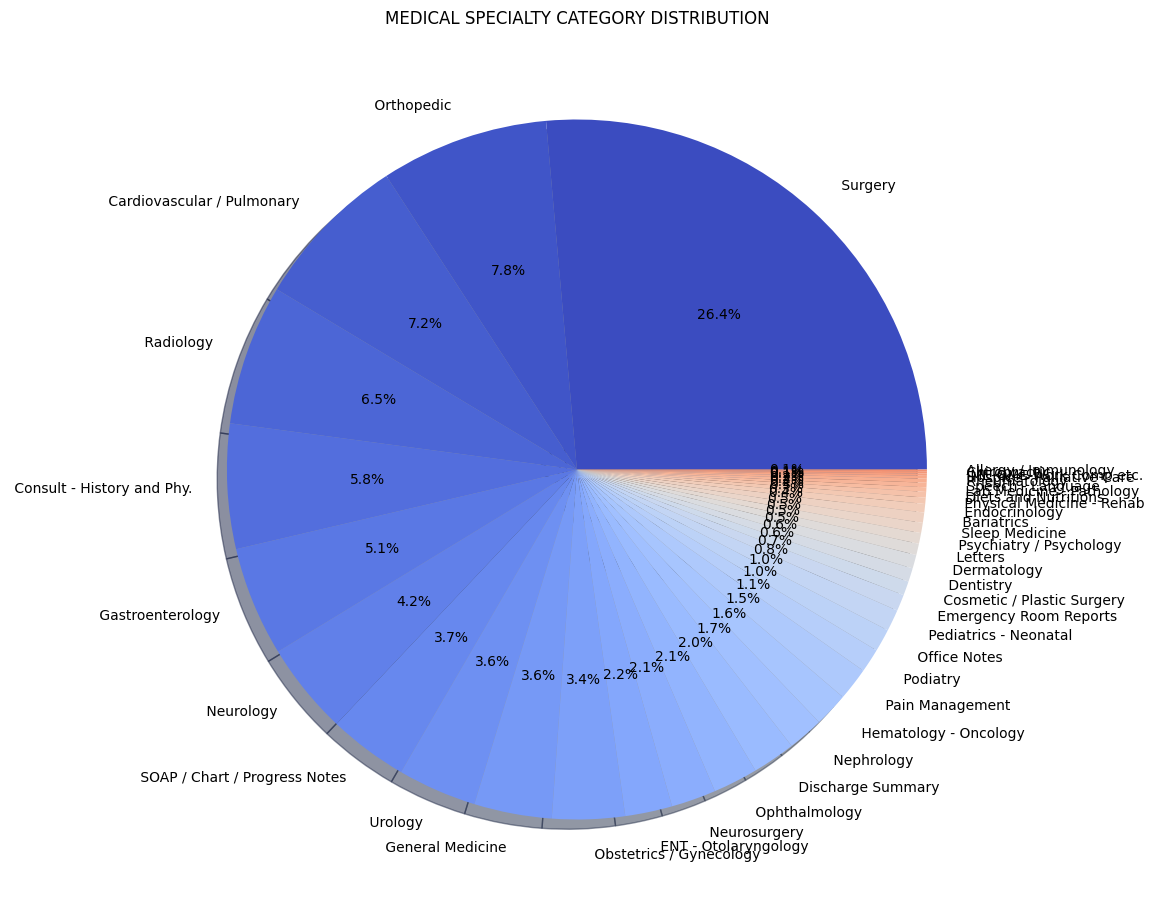

In [ ]:
targetCounts = df['medical_specialty'].value_counts()
targetLabels  = targetCounts.index
# Make square figures and axes
plt.figure(1, figsize=(25,25))
the_grid = GridSpec(2, 2)


cmap = plt.get_cmap('coolwarm')
colors = [cmap(i) for i in np.linspace(0, 1)]
plt.subplot(the_grid[0, 1], aspect=1, title='MEDICAL SPECIALTY CATEGORY DISTRIBUTION')

source_pie = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True, colors=colors)
plt.show()

### Pre-process `transcription` and `keywords` text

**Step 5: Create functions to perform below tasks:**

- Convert transcription and keywords text to lowercase
- Remove quotes from transcription and keywords text
- Remove all the special characters/punctuations
- Remove digits from transcription and keywords text
- Remove extra spaces

- **Convert `transcription` and `keywords` text to lowercase**

In [ ]:
# Convert transcription and keywords text to lowercase
df.transcription = df.transcription.apply(lambda x: str(x).lower())
df.keywords = df.keywords.apply(lambda x: str(x).lower())

- **Remove quotes from `transcription` and `keywords` text**

In [ ]:
# Remove quotes from transcription and keywords text
df.transcription = df.transcription.apply(lambda x: re.sub("'", '', x))
df.keywords = df.keywords.apply(lambda x: re.sub("'", '', x))

- **Remove punctuations**

In [ ]:
# create a set of all special characters
special_characters = set(string.punctuation)
print(special_characters)

{'!', '>', '}', "'", '|', '[', '\\', '^', '-', '/', '_', ',', '*', '=', ':', '#', '~', '&', '%', ')', '+', '?', '`', '.', '"', ';', ']', '$', '(', '@', '{', '<'}


In [ ]:
# Remove punctuations
df.transcription = df.transcription.apply(lambda x: ''.join(char1 for char1 in x if char1 not in special_characters))
df.keywords = df.keywords.apply(lambda x: ''.join(char1 for char1 in x if char1 not in special_characters))

- **Remove digits from `transcription` and `keywords` text**

In [ ]:
# Remove digits from transcription and keywords sentences
df.transcription = df.transcription.apply(lambda x: re.sub("\d", '', x))
df.keywords = df.keywords.apply(lambda x: re.sub("\d", '', x))

- **Remove extra spaces**

In [ ]:
# Remove extra spaces
df.transcription = df.transcription.apply(lambda x: x.strip())
df.keywords = df.keywords.apply(lambda x: x.strip())

df.transcription = df.transcription.apply(lambda x: re.sub(" +", " ", x))
df.keywords = df.keywords.apply(lambda x: re.sub(" +", " ", x))

**Step 6: Remove the stopwords from `transcription` text**

- **Remove stopwords**

In [ ]:
# setting english stopwords
stopword_list = nltk.corpus.stopwords.words('english')
print(stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
# Function to remove the stopwords
def remove_stopwords(text):
    tmp = []
    for word in text.split():
        if word not in stopword_list:
            tmp.append(word)

    return ' '.join(tmp)

In [ ]:
# Remove stopwords from transcriptions
df['transcription'] = df['transcription'].apply(lambda x: remove_stopwords(str(x)))

**Visualize the distribution of word counts in both `transcription` and `keywords` text.**


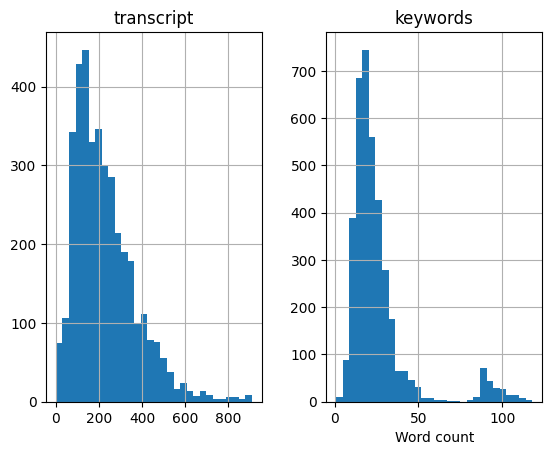

In [ ]:
# Visualize the distribution of word counts

transcript_word_count = []
keywords_word_count = []

# Sentence lengths for transcripts
for i in df['transcription']:
    transcript_word_count.append(len(i.split()))

# Sentence lengths for keywords
for i in df['keywords']:
    keywords_word_count.append(len(i.split()))

length_df = pd.DataFrame({'transcript': transcript_word_count, 'keywords': keywords_word_count})
length_df.hist(bins = 30)
plt.xlabel('Word count')
plt.show()

### Select the maximum sequence length for both `transcription` and `keywords`

In [ ]:
# Fix the maximum length of the transcript to 250
# Fix the maximum keywords length to 30

max_len_transcript = 250
max_len_keywords = 30

**Step 7: Add `'start'` and `'end'` to `keywords` text at the beginning and end respectively**

- 'start' will represent the beginning of output sequence
- 'end' will represent the end of output sequence

In [ ]:
# Add 'start' and 'end' to keywords text

df['keywords'] = df['keywords'].apply(lambda x: 'start ' + str(x) + ' end')

In [ ]:
df.head(1)

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,subjective yearold white female presents complaint allergies used allergies lived seattle thinks worse past tried claritin zyrtec worked short time seemed lose effectiveness used allegra also used...,start allergy immunology allergic rhinitis allergies asthma nasal sprays rhinitis nasal erythematous allegra sprays allergic end


### Split data into training and testing set

In [ ]:
x_tr, x_val, y_tr, y_val = train_test_split(df['transcription'].astype(str), df['keywords'].astype(str),
                                            test_size=0.1,
                                            random_state=0,
                                            shuffle=True)

x_tr.shape, x_val.shape, y_tr.shape, y_val.shape

((3435,), (382,), (3435,), (382,))

### Tokenization and padding

**Step 8: Convert the `transcription` and `keywords` text to sequence of integer values, and make them of uniform length**

- Use two tokenizers to tokenize transcription and keywords separately
- Pad/Truncate both sequences as per their max sequence length specified in above steps
    - use padding='post', truncating='post'
    - for transcription, (use maxlen= max_len_transcript)
    - for keywords, (use maxlen= max_len_keywords + 1)
- For long keywords sequences, the 'end' token might get truncated
    - replace the last token with the token index of 'end'
- save the vocab size for both sequences

In [ ]:
# Instantiate tokenizer for transcripts and fit on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

# Convert transcript sequences into integer sequences for both train and val set
x_tr = x_tokenizer.texts_to_sequences(x_tr)
x_val = x_tokenizer.texts_to_sequences(x_val)

# Add zero padding upto maximum length
x_tr = pad_sequences(x_tr,  maxlen= max_len_transcript, padding='post', truncating='post')
x_val = pad_sequences(x_val, maxlen= max_len_transcript, padding='post', truncating='post')

# x vocab size
x_voc_size = len(x_tokenizer.word_index) +1
x_voc_size

26900

In [ ]:
x_tr.shape, x_val.shape

((3435, 250), (382, 250))

In [ ]:
# Instantiate tokenizer for keywords and fit on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

# Convert keywords sequences into integer sequences for train and val set
y_tr = y_tokenizer.texts_to_sequences(y_tr)
y_val = y_tokenizer.texts_to_sequences(y_val)

# Add zero padding upto maximum length
y_tr = pad_sequences(y_tr, maxlen= max_len_keywords + 1, padding='post', truncating='post')
y_val = pad_sequences(y_val, maxlen= max_len_keywords + 1, padding='post', truncating='post')

# y vocab size
y_voc_size = len(y_tokenizer.word_index) +1
y_voc_size

5918

In [ ]:
y_tr.shape, y_val.shape

((3435, 31), (382, 31))

- **For long keywords sequences, replace the last token with the token index of 'end'**

In [ ]:
y_tokenizer.word_index['end']

1

In [ ]:
# Replace the last token with the token index of 'end' for long sequences

# Train set
for i in range(len(y_tr)):
    if y_tr[i][-1] != 0:
        y_tr[i][-1] = y_tokenizer.word_index['end']

# Validation set
for i in range(len(y_val)):
    if y_val[i][-1] != 0:
        y_val[i][-1] = y_tokenizer.word_index['end']


In [ ]:
y_tr[0]

array([   2,   37,   30,    4,   43,  375,  419, 1216,  765, 1216, 3225,
        419,  462, 5373,  462, 5374,  937, 5375, 5376, 5377, 5378,    4,
       5379,  264,  621, 2514,  561,  111, 3226,  375,    1], dtype=int32)

In [ ]:
y_val[0]

array([   2,   23,  304,   97,    3, 2193,  706, 5283, 5284,  100,  191,
        439,  161,  191,  439,  161, 2972,  101,  439,  161,  191,  167,
       5615, 1281,  161, 5615,  998,  191,    1,    0,    0], dtype=int32)

In [ ]:
print(f"Decoder input sample: {y_tr[0][:-1]}")
print(f"Decoder output sample: {y_tr[0][1:]}")

Decoder input sample: [   2   37   30    4   43  375  419 1216  765 1216 3225  419  462 5373
  462 5374  937 5375 5376 5377 5378    4 5379  264  621 2514  561  111
 3226  375]
Decoder output sample: [  37   30    4   43  375  419 1216  765 1216 3225  419  462 5373  462
 5374  937 5375 5376 5377 5378    4 5379  264  621 2514  561  111 3226
  375    1]


### Positional Embedding

**Step 9: Create a class, `PositionalEmbedding`**

- Use `mask_zero=True`, while defining token embeddings layer

- Make sure to make this layer a mask-generating layer by adding a method `compute_mask()`

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        # input_dim = (token) vocabulary size,  output_dim = embedding size
        super().__init__(**kwargs)

        self.token_embeddings = layers.Embedding(input_dim=input_dim, output_dim=output_dim, mask_zero=True)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):   # inputs will be a batch of sequences (batch, seq_len)
        length = tf.shape(inputs)[-1]     # lenght will just be sequence length
        positions = tf.range(start=0, limit=length, delta=1) # indices for input to positional embedding
        embedded_tokens = tf.reshape(self.token_embeddings(inputs), (-1, length, self.output_dim))
        embedded_positions = tf.reshape(self.position_embeddings(positions), (-1, length, self.output_dim))
        return layers.Add()([embedded_tokens, embedded_positions])     # ADD the embeddings

    def compute_mask(self, inputs, mask=None):  # makes this layer a mask-generating layer, mask will get propagated to the next layer.
        if mask is None:
            return None
        return tf.math.not_equal(inputs, 0)

    # When using custom layers, this enables the layer to be reinstantiated from its config dict,
    # which is useful during model saving and loading.
    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

### Encoder Block

**Step 10: Create a class, `TransformerEncoder`**

- While calling `attention` layer, do not use `attention_mask` parameter

- In Feed forward network, add `Dropout(0.1)` layer after 2 dense layers

- For skip connections, use `tf.keras.layers.Add()` instead of `'+'`

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim    # Dimension of embedding
        self.dense_dim = dense_dim    # No. of neurons in dense layer
        self.num_heads = num_heads    # No. of heads for MultiHead Attention layer
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)   # MultiHead Attention layer
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"),
                                            layers.Dense(embed_dim),
                                            layers.Dropout(0.1),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.add = layers.Add()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
            print(f"**test: mask in not None. mask = {mask}")

        attention_output = self.attention(query=inputs,             # Query: inputs,
                                          value=inputs,             # Value: inputs,
                                          key=inputs,               # Keys: Same as Values by default
                                          attention_mask=mask
                                          )                         # Q: Can you see how this is self attention? A: all args are the same

        proj_input = self.layernorm_1(self.add([inputs, attention_output]))

        proj_output = self.dense_proj(proj_input)

        return self.layernorm_2(self.add([proj_input, proj_output]))

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return

### Decoder Block

**Step 11: Create a class, `TransformerDecoder`**

- Do not create any separate function to get causal attention mask, just pass `use_causal_mask = True` parameter while calling `attention_1` layer

- While calling `attention_2` layer, do not use `attention_mask` parameter

- In Feed forward network, add `Dropout(0.1)` layer after 2 dense layers

- For skip connections, use `tf.keras.layers.Add()` instead of `'+'`

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        # Define the layers. Let's point them out in the diagram
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        # Now we have 2 MultiHead Attention layers - one for self attention and one for generalized attention
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"),
                                            layers.Dense(embed_dim),
                                            layers.Dropout(0.1),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.add = layers.Add()
        self.supports_masking = True #ensures that the layer will propagate its input mask to its outputs;

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config


    def call(self, inputs, encoder_outputs, mask=None): # two inputs: decoder i/p and encoder o/p

        attention_output_1 = self.attention_1(query=inputs,
                                              value=inputs,
                                              key=inputs,
                                              use_causal_mask = True)

        attention_output_1 = self.layernorm_1(self.add([inputs, attention_output_1]))

        attention_output_2 = self.attention_2(query=attention_output_1,
                                              value=encoder_outputs,
                                              key=encoder_outputs)

        attention_output_2 = self.layernorm_2(self.add([attention_output_1, attention_output_2]))

        proj_output = self.dense_proj(attention_output_2)

        return self.layernorm_3(self.add([attention_output_2, proj_output]))

### Build Transformer model

**Step 12: Create a transformer model with below points:**

- Use the respective vocabulary size for PositionalEmbedding of encode and decoder inputs

- Add `Dropout(0.1)` layers after both encoder and decoder PositionalEmbedding layers

- Do not use `activation="softmax"` for the last dense classification layer (You will be required to create a custom loss, and metric in the next stage.)

- Add a stack of 4 encoder blocks and 4 decoder blocks to your transformer

In [ ]:
# Create transformer model

embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,))
x = PositionalEmbedding(max_len_transcript, x_voc_size, embed_dim)(encoder_inputs)
x = layers.Dropout(0.1)(x)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,))
x = PositionalEmbedding(max_len_keywords, y_voc_size, embed_dim)(decoder_inputs)
x = layers.Dropout(0.1)(x)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)

decoder_outputs = layers.Dense(y_voc_size)(x)         #, activation="softmax")(x)

transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

transformer.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding_2    │ (None, None, 256)      │      6,950,400 │ input_layer_10[0][0]   │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout)      │ (None, None, 256)      │              0 │ positional_embedding_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_4     │ (None, None, 256)      │      3,155,456 │ dropout_23[0][0]       │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_15            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_5     │ (None, None, 256)      │      3,155,456 │ transformer_encoder_4… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding_3    │ (None, None, 256)      │      1,522,688 │ input_layer_15[0][0]   │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_6     │ (None, None, 256)      │      3,155,456 │ transformer_encoder_5… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_32 (Dropout)      │ (None, None, 256)      │              0 │ positional_embedding_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_7     │ (None, None, 256)      │      3,155,456 │ transformer_encoder_6… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_decoder_4     │ (None, None, 256)      │      5,259,520 │ dropout_32[0][0],      │
│ (TransformerDecoder)      │                        │                │ transformer_encoder_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_decoder_5     │ (None, None, 256)      │      5,259,520 │ transformer_decoder_4… │
│ (TransformerDecoder)      │                        │                │ transformer_encoder_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_decoder_6     │ (None, None, 256)      │      5,259,520 │ transformer_decoder_5… │
│ (TransformerDecoder)      │                        │                │ transformer_encoder_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_decoder_7     │ (None, None, 256)      │      5,259,520 │ transformer_decoder_6… │
│ (TransformerDecoder) 

 Total params: 43,653,918 (166.53 MB)

 Trainable params: 43,653,918 (166.53 MB)

 Non-trainable params: 0 (0.00 B)

## Model Compilation and Training

**Step 13: Set up the optimizer**

Refer [here](https://www.tensorflow.org/text/tutorials/transformer#set_up_the_optimizer) for the following steps:

- Use the Adam optimizer with a custom learning rate scheduler

- Instantiate the Adam optimizer with custom learning rate

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
# Instantiate the Adam optimizer with custom learning rate

learning_rate = CustomSchedule(embed_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

**Step 14: Set up the loss and metrics**

- Apply a padding mask while calculating the loss with cross-entropy loss function as demonstrated [here](https://www.tensorflow.org/text/tutorials/transformer#set_up_the_loss_and_metrics).  

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

**Step 15: Compile transformer model with custom optimizer, loss, and metric & perform training**

- Use [*transcription sequences*, and *keywords sequences(shifted right)*] as input to transformer

- Train model using colab's GPU runtime with batch_size=32, and epochs=30. (It might take one minute per epoch with GPU)


In [ ]:
# Compile
transformer.compile(loss=masked_loss,
                    optimizer=optimizer,
                    metrics=[masked_accuracy])

In [ ]:
y_tr.shape

(3435, 31)

In [ ]:
y_tr[:, :-1].shape, y_tr[:, 1:].shape

((3435, 30), (3435, 30))

In [ ]:
# Train
transformer.fit([x_tr, y_tr[:,:-1]], y_tr[:, 1:],
                epochs=30,
                batch_size=32,
                validation_data=([x_val, y_val[:,:-1]], y_val[:,1:]))

Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 145s 803ms/step - loss: 8.6825 - masked_accuracy: 0.0124 - val_loss: 8.2781 - val_masked_accuracy: 0.0575
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 77s 478ms/step - loss: 8.2128 - masked_accuracy: 0.0584 - val_loss: 7.7947 - val_masked_accuracy: 0.0706
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 84s 495ms/step - loss: 7.7182 - masked_accuracy: 0.0743 - val_loss: 7.3144 - val_masked_accuracy: 0.0820
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 82s 494ms/step - loss: 7.2588 - masked_accuracy: 0.0871 - val_loss: 6.9006 - val_masked_accuracy: 0.1167
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 81s 488ms/step - loss: 6.8238 - masked_accuracy: 0.1210 - val_loss: 6.4743 - val_masked_accuracy: 0.1467
Epoch 6/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 82s 489ms/step - loss: 6.3681 - masked_accuracy: 0.1447 - val_loss: 6.0307 - val_masked_accuracy: 0.1771
Epoch 7/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 83s 495ms/step - loss: 5.8594 - masked_accuracy: 0.1840 - val_loss: 5.6470 - val_masked_a

### Save model weights

In [ ]:
!mkdir my_model_weights

In [ ]:
# Save model weights
# It will create a '.weights.h5' file which can be downloaded into your system from colab

transformer.save_weights('my_model_weights/my_weights.weights.h5')

In [ ]:
# OR
# Make a zip file, which also can be downloaded into your system from colab

!zip -r 'my_model_weights.zip' 'my_model_weights'

  adding: my_model_weights/ (stored 0%)
  adding: my_model_weights/my_weights.weights.h5 (deflated 9%)


### Load model weights

Whenever you need to use this trained model:
* use the model architecture to create exact same model
* then load the trained weights directly using below code

In [ ]:
# To load model weights
#transformer.load_weights('my_model_weights/my_weights.weights.h5')

## Run Inference

**Step 16: Create a function to extract keywords, given transcription text as input**

- Encode the input sentence using the Transcription tokenizer. This is the encoder input
- Initialize decoder input with the 'start' token
- The decoder then outputs the predictions by looking at the encoder output and its own output (self-attention).
- Concatenate the predicted token to the decoder input and pass it to the decoder repeatedly
- Make decoder predict the next token based on the previous tokens it has predicted

In [ ]:
def extract_keywords(sentence, transformer=transformer):

    """ Takes an input sentence, and transformer. Returns extracted keywords. """

    # Convert input sentence into integer sequence (Note that tokenizer.texts_to_sequences() take list of text as input)
    ip_tokens = x_tokenizer.texts_to_sequences([sentence])

    # Add zero padding upto maximum length transcription
    ip_tok_seq = pad_sequences(ip_tokens,  maxlen= max_len_transcript, padding='post', truncating='post')

    # Create a decoder sequence with 'start' token index
    dec_tok_seq = np.array([y_tokenizer.word_index['start']])

    # Variable to store the output text string
    keyword_sentence = ''

    for i in range(max_len_keywords):

        # Get output logits from transformer
        pred = transformer([ip_tok_seq.reshape(1,-1), dec_tok_seq.reshape(1, -1)], training=False)
        pred = pred[:, -1:, :]

        # Select the index with max value from 'pred' to get the output token index
        max_index = tf.argmax(pred, axis=-1)
        token = max_index.numpy()[0][0]

        # Convert output token to word
        word = y_tokenizer.index_word[token]

        # End the loop if word is 'end'
        if word == 'end':
            break

        # Append 'token' to dec_tok_seq
        dec_tok_seq = np.append(dec_tok_seq, token)

        # Append 'word' to decoded sentence
        keyword_sentence += ' ' + word

    return keyword_sentence.strip()


In [ ]:
df['keywords'].iloc[0]

'start allergy immunology allergic rhinitis allergies asthma nasal sprays rhinitis nasal erythematous allegra sprays allergic end'

In [ ]:
# Predicted keywords sample
extract_keywords(df['transcription'].iloc[0], transformer)

'soap chart progress notes allergic rhinitis allergies asthma nasal sprays rhinitis nasal erythematous allegra sprays allergic'

In [ ]:
# Split text data
x_tr_sen, x_val_sen, y_tr_lab, y_val_lab = train_test_split(df['transcription'].astype(str), df['keywords'].astype(str),
                                                            test_size=0.1,
                                                            random_state=0,
                                                            shuffle=True)

x_tr_sen.shape, x_val_sen.shape, y_tr_lab.shape, y_val_lab.shape

((3435,), (382,), (3435,), (382,))

In [ ]:
# Prediction on training set

for i in range(10):

    try:
        print("Transcript:", x_tr_sen.iloc[i])
        print("Original keywords:", y_tr_lab.iloc[i])
        print("Predicted keywords:", extract_keywords(x_tr_sen.iloc[i], transformer))
        print("\n")
    except:
        pass

Transcript: subjective followup dietary consultation polycystic ovarian syndrome hyperlipidemia patient reports resumed food record keeping feels like given greater control physical activity level remained high struggle times midafternoon enough food eat well evening dinnerobjective vital signs weight pounds food records reviewedassessment patient experienced weight loss pounds last month commended efforts reviewed food records identifying done nice job keeping calorie count last two three weeks discussed value difficulty resume however suspended record keeping also discussed reflection getting many fruits vegetables regular basis identified ways preventing feeling sluggish problems low blood sugar middle afternoon routinely planning afternoon snack prevent symptoms likely around pm also discussed strategies evening snacking help put definition boundaries snackingplan recommended patient routinely include afternoon snack around pm helpful snack includes protein nuts lowfat cheese also 

In [ ]:
# Prediction on validation set

for i in range(10):

    try:
        print("Transcript:", x_val_sen.iloc[i])
        print("Original keywords:", y_val_lab.iloc[i])
        print("Predicted keywords:", extract_keywords(x_val_sen.iloc[i], transformer))
        print("\n")
    except:
        pass

Transcript: operation lumbar epidural steroid injection intralaminar approach seated positionanesthesia
Original keywords: start pain management loss of resistance technique methylprednisolone acetate lumbar epidural steroid injection epidural steroid injection tuohy needle steroid injection epidural space intralaminar approach injection intralaminar saline epidural end
Predicted keywords: pain management epidural space lumbar epidural steroid injection tuohy needle steroid injection bovie pain trigger


Transcript: reason admission intraperitoneal chemotherapyhistory pleasant yearold hypertensive nondiabetic africanamerican female history peritoneal mesothelioma patient received prior intravenous chemotherapy due increasing renal insufficiency difficulties hydration elected change intraperitoneal therapy first course intraperitoneal cisplatin difficultly tolerated therefore last hospitalization ip chemo switched taxol patient since last visit done relatively well acute problems basica

## Gradio Implementation

Gradio is an open-source python library that allows us to quickly create easy-to-use, customizable UI components for our ML model, any API, or any arbitrary function in just a few lines of code. We can integrate the GUI directly into the Python notebook, or we can share the link with anyone.

In [ ]:
!pip -qq install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.9 MB/s eta 0:00:00


In [ ]:
import gradio

In [ ]:
# Input sample
x_tr_sen.iloc[1]

'admitting diagnoses left renal cell carcinoma left renal cystdischarge diagnosis left renal cell carcinoma left renal cystsecondary diagnoses chronic obstructive pulmonary disease coronary artery diseaseprocedures roboticassisted laparoscopic left renal cyst decortication cystoscopyhistory present illness mr abc yearold male diagnosed left renal cell carcinoma multiple renal cysts undergone mri abdomen june revealing enhancing mass upper pole left kidney consistent history renal cell carcinoma note enhancing solid masses seen mri discussion multiple management strategies patient including left partial nephrectomy left radical nephrectomy left renal cyst decortication patient likely undergo latter procedurehospital course patient admitted undergo left renal cyst decortication well cystoscopy intraoperatively approximately four enlarged renal cysts six smaller renal cysts initially removed contents aspirated careful dissection cyst wall performed multiple specimens cyst wall sent pathol

In [ ]:
# Input from user
in_transcript = gradio.Textbox(lines=10, placeholder=None, value="transcription", label='Enter Transcription Text')

# Output prediction
out_keywords = gradio.Textbox(type="text", label='Extracted Keywords')


# Gradio interface to generate UI
iface = gradio.Interface(fn = extract_keywords,
                         inputs = [in_transcript],
                         outputs = [out_keywords],
                         title = "Keywords Extraction",
                         description = "Using transformer model, trained from scratch",
                         allow_flagging = 'never')

iface.launch(share = True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://f6a0145fc2b5e44792.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Click on the link generated above to access the UI.